In [1]:
# https://yt-project.org/
# Import the shiiiii

import yt
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
from FLASH_functions import *
sys.path.append('../analysis_scripts')
from real_units_to_sim import get_osiris_units

# Assuming the correct numerical values are input into the file real_units_to sim, this should spit out the correct simulation values 
osiris = get_osiris_units()

---------- n_e = 7.8e+18 cm^-3 ----------
angular electron plasma frequency is: 1.58e+14 rad/s
--------------------------------------------------
times are normalized to inverse plasma frequency, one unit of simulation time corresponds to 6.35e-06 ns
space is normalized to electron inertial length, one unit of simulation length corresponds to 1.90e-04 cm
--------------------------------------------------
110000 G in simulation units would be 0.012

electron gyrotime would be 0.0005 ns
this corresponds to 81.438 simulation times

ion gyrotime (with ion mass of 100) would be 0.0517 ns
this corresponds to 8143.756 simulation times
--------------------------------------------------
alfven speed is 3.68e+07 cm/s
in simulation units this would be 0.001228

In order to simulate 5 ion gyrotimes by the time the shock has reached halfway across the box
we should set tmax = 40718
and the maximum bound of the box should be approx 1333
--------------------------------------------------
Te of 1118.0

## First, let's just take a look at some slices of the data

In [2]:
# plot_path = "./OSIRIS_transfer/MAGOFF/MagShockZ_hdf5_plt_cnt_0004"
plot_path = "./OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

ds = yt.load(plot_path)
list(ds.fields.flash)

yt : [INFO     ] 2024-08-21 15:05:53,710 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-08-21 15:05:53,778 Parameters: current_time              = 1.8520020414484505e-09
yt : [INFO     ] 2024-08-21 15:05:53,779 Parameters: domain_dimensions         = [288 272 288]
yt : [INFO     ] 2024-08-21 15:05:53,780 Parameters: domain_left_edge          = [-0.6   -0.075 -0.6  ]
yt : [INFO     ] 2024-08-21 15:05:53,781 Parameters: domain_right_edge         = [0.6 1.  0.6]
yt : [INFO     ] 2024-08-21 15:05:53,782 Parameters: cosmological_simulation   = 0


[On-Disk Field ('flash', 'absr'): (units: '', display_name: 'Absorption Coefficient'),
 On-Disk Field ('flash', 'cham'): (units: '', display_name: 'Chamber Material Fraction'),
 On-Disk Field ('flash', 'cond'): (units: '', display_name: 'Conductivity'),
 On-Disk Field ('flash', 'dbgs'): (units: '', display_name: 'Debug for Shocks'),
 On-Disk Field ('flash', 'dens'): (units: 'code_mass/code_length**3'),
 On-Disk Field ('flash', 'depo'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'dfcf'): (units: '', display_name: 'Diffusion Equation Scalar'),
 On-Disk Field ('flash', 'divb'): (units: 'code_magnetic/code_length'),
 On-Disk Field ('flash', 'eele'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Electron Internal Specific Energy'),
 On-Disk Field ('flash', 'eint'): (units: 'code_length**2/code_time**2'),
 On-Disk Field ('flash', 'eion'): (units: 'code_mass * (code_length/code_time)**2', display_name: 'Ion Internal Specific Energy'),
 On-Disk Field ('

In [3]:
# relevant vars

print(ds.units)
print(ds.length_unit)
print(ds.mass_unit)
print(ds.domain_dimensions)
print(ds.refine_by)

1.0 cm
1.0 g
[288 272 288]
2


yt : [INFO     ] 2024-08-21 15:05:56,509 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:05:56,510 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:05:56,515 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:05:56,517 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:05:56,523 Making a fixed resolution buffer of (('flash', 'dens')) 800 by 800


dens at [0.  0.4 0. ] code_length: [2.48007124e-05] code_mass/code_length**3



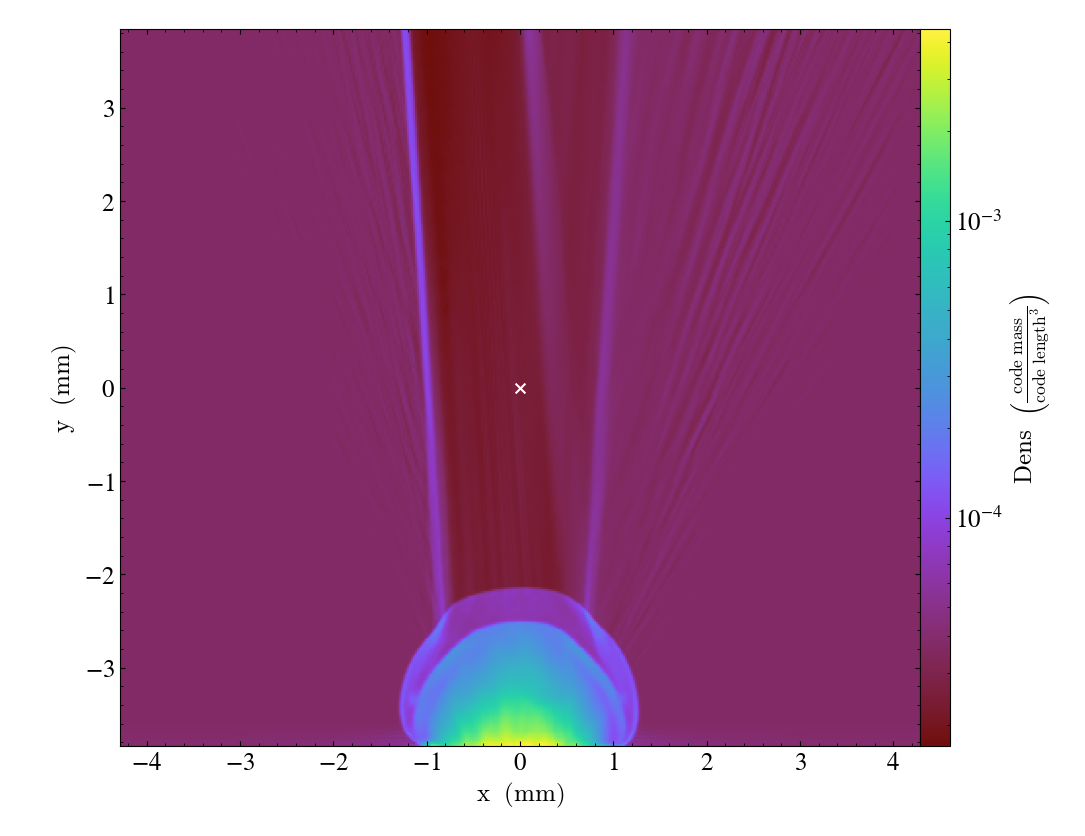

In [4]:
# Find some points in the background to pull values from

# background_pt = [-0.4, 0.3, 0.0]
background_pt = [0, 0.4, 0.0]

rho_0 = pull_value_at_coord(background_pt,'dens',ds)

# looks good

In [5]:
# perform appropriate conversions to get the number density of ions and electrons

def make_ion_number_density(field, data):
    avogadro = 6.022e23
    ion_number_density = avogadro*data["flash","dens"]*data["flash","sumy"]
    return ion_number_density

def make_electron_number_density(field, data):
    avogadro = 6.022e23
    electron_number_density = avogadro*data["flash","dens"]*data["flash","ye"]
    return electron_number_density

def make_ele_per_ion(field, data):
    return data['flash','edens']/data['flash','idens']

ds.add_field(("flash", "idens"), function=make_ion_number_density, units="code_mass/code_length**3",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "edens"), function=make_electron_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here
ds.add_field(("flash", "ele_per_ion"), function=make_ele_per_ion,units =  "", sampling_type="cell")

yt : [INFO     ] 2024-08-21 17:08:18,927 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:08:18,928 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-21 17:08:18,931 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:08:18,932 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-21 17:08:18,933 Making a fixed resolution buffer of (('flash', 'ele_per_ion')) 800 by 800



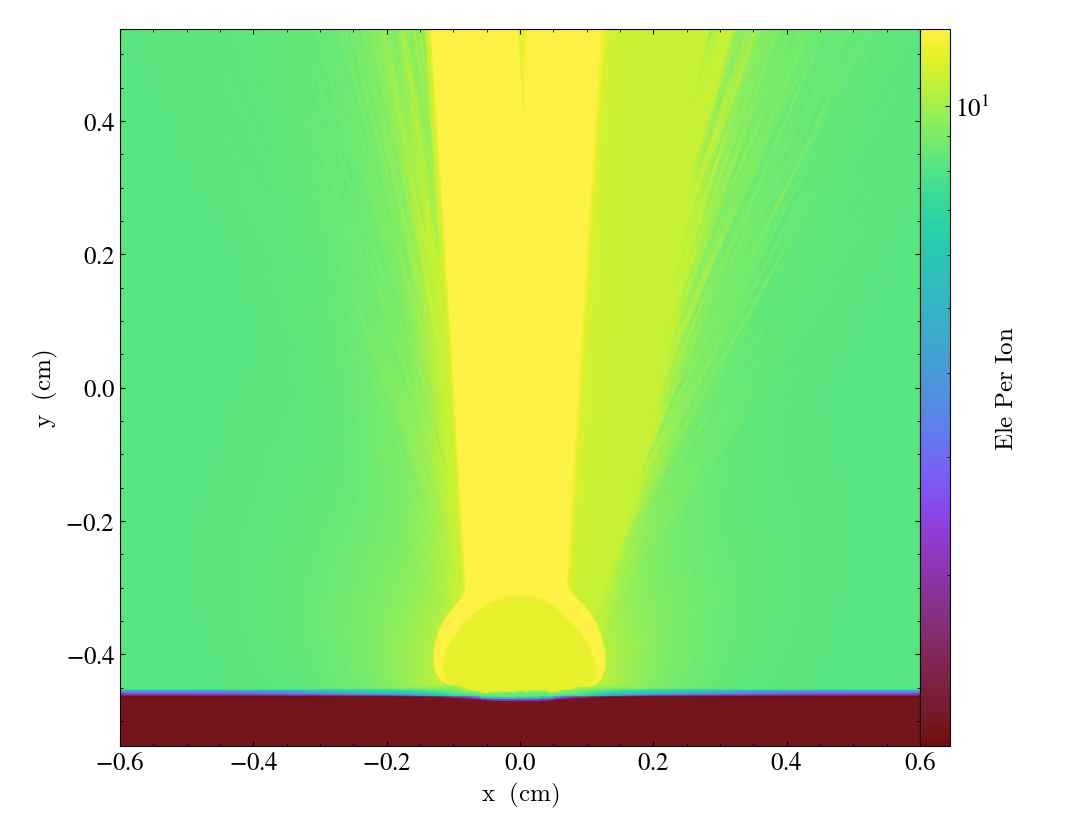

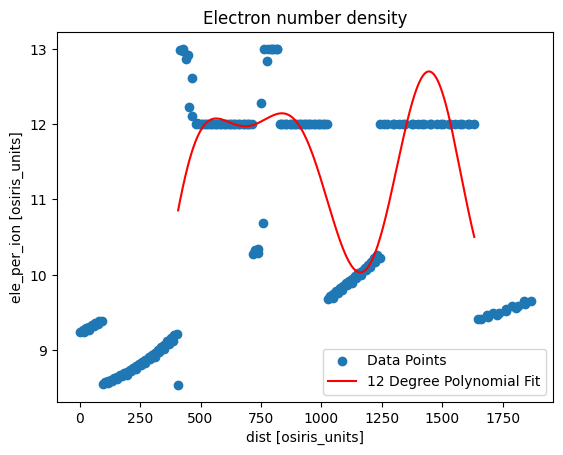

"if(x1 < 407.344845,  (20196.384101)*((x1 - 1632.990595)/-1225.64575)^(12) + (-137200.211114)*((x1 - 1632.990595)/-1225.64575)^(11) + (389960.447644)*((x1 - 1632.990595)/-1225.64575)^(10) + (-595232.832215)*((x1 - 1632.990595)/-1225.64575)^(9) + (515090.1304)*((x1 - 1632.990595)/-1225.64575)^(8) + (-235627.309285)*((x1 - 1632.990595)/-1225.64575)^(7) + (35000.221425)*((x1 - 1632.990595)/-1225.64575)^(6) + (11589.546345)*((x1 - 1632.990595)/-1225.64575)^(5) + (-3524.578482)*((x1 - 1632.990595)/-1225.64575)^(4) + (-345.610721)*((x1 - 1632.990595)/-1225.64575)^(3) + (78.1616)*((x1 - 1632.990595)/-1225.64575)^(2) + (16.002652)*((x1 - 1632.990595)/-1225.64575)^(1) + (10.502005)*((x1 - 1632.990595)/-1225.64575)^(0), 0.0)",

----------Desmos formatting to check your work----------

(20196.384101)*((x - 1632.990595)/-1225.64575)^12 + (-137200.211114)*((x - 1632.990595)/-1225.64575)^11 + (389960.447644)*((x - 1632.990595)/-1225.64575)^10 + (-595232.832215)*((x - 1632.990595)/-1225.64575)^9 + (5

In [42]:
slc = yt.SlicePlot(ds, "z", ("flash", 'ele_per_ion'))
slc.show()

from fitting_functions import fit_to_region
plt.title('Electron number density')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.2,0.0],field='ele_per_ion',degree=12,ds=ds, normalization=1, osiris=osiris,precision=6,left_value=None, right_value=0.0)

yt : [INFO     ] 2024-08-21 17:09:37,203 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:37,204 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:37,205 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:37,206 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:37,206 Making a fixed resolution buffer of (('flash', 'ele_per_ion')) 800 by 800


ele_per_ion at [-0.4  0.4  0. ] code_length: [8.24009053] dimensionless



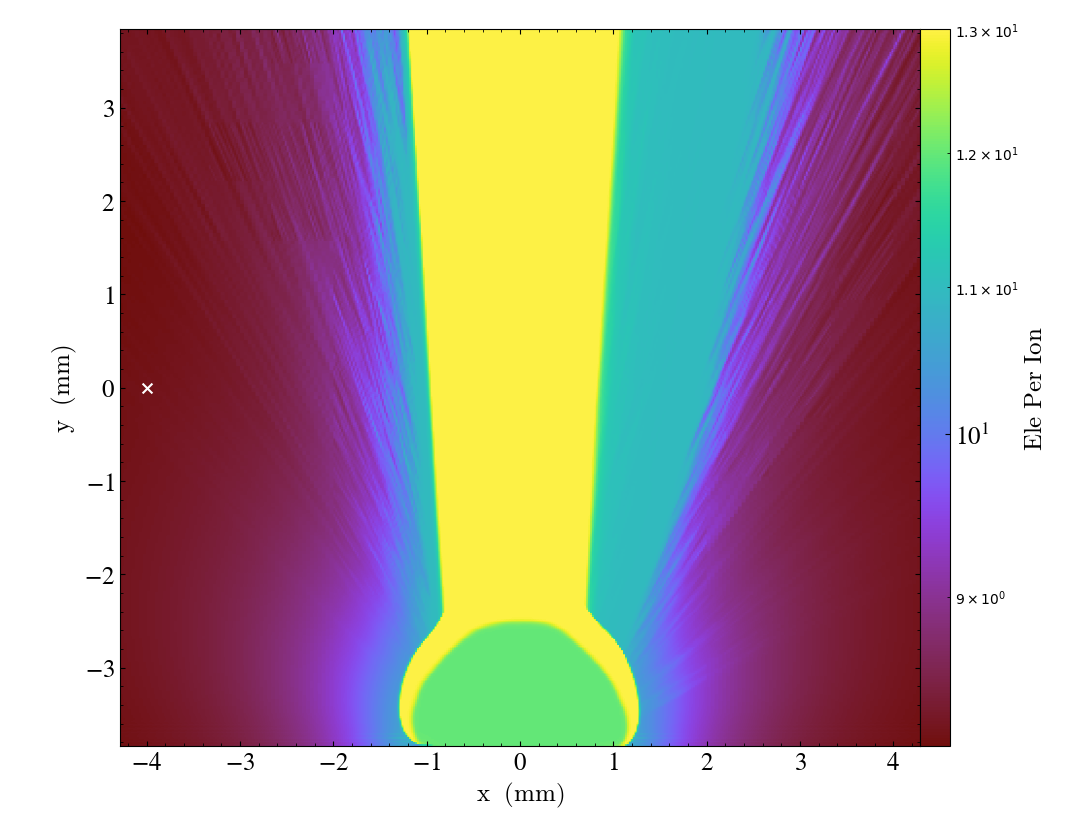

yt : [INFO     ] 2024-08-21 17:09:37,614 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:37,614 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:37,617 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:37,618 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:37,620 Making a fixed resolution buffer of (('flash', 'idens')) 800 by 800


idens at [0.  0.4 0. ] code_length: [5.53557785e+17] code_mass/code_length**3



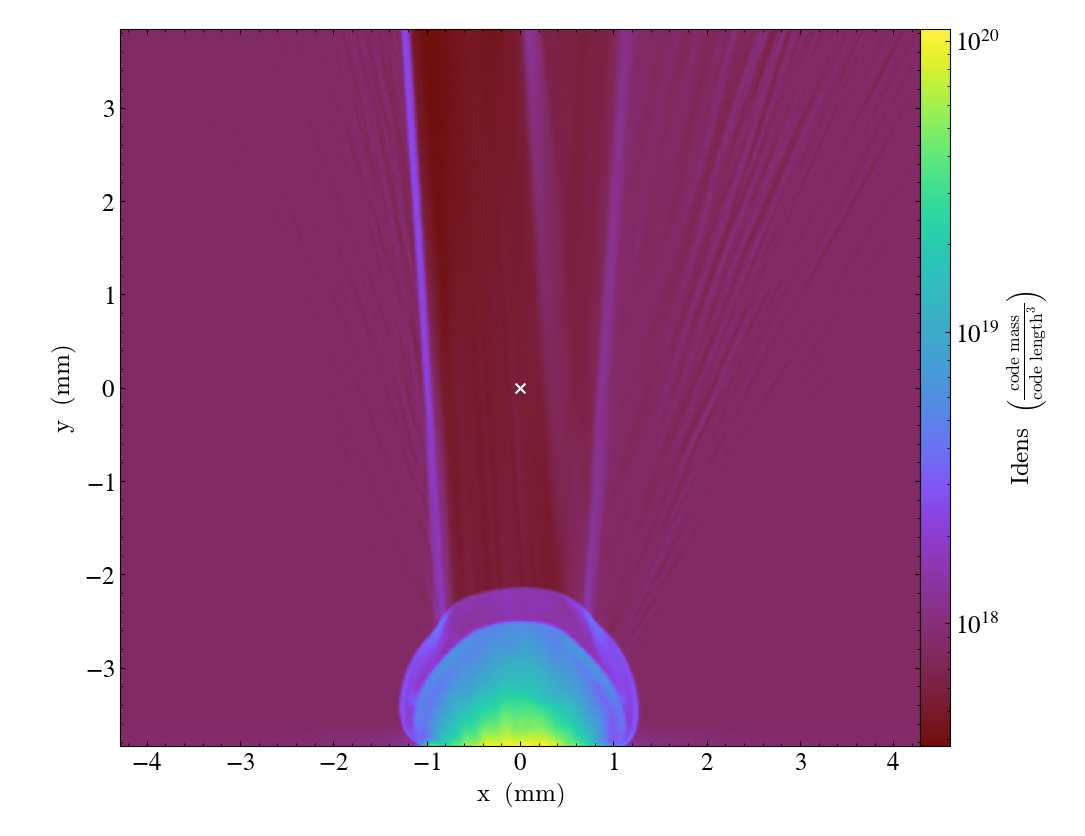

yt : [INFO     ] 2024-08-21 17:09:38,087 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:38,088 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:38,089 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:38,090 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:38,091 Making a fixed resolution buffer of (('flash', 'ye')) 800 by 800


ye at [0.  0.4 0. ] code_length: [0.4818383] dimensionless



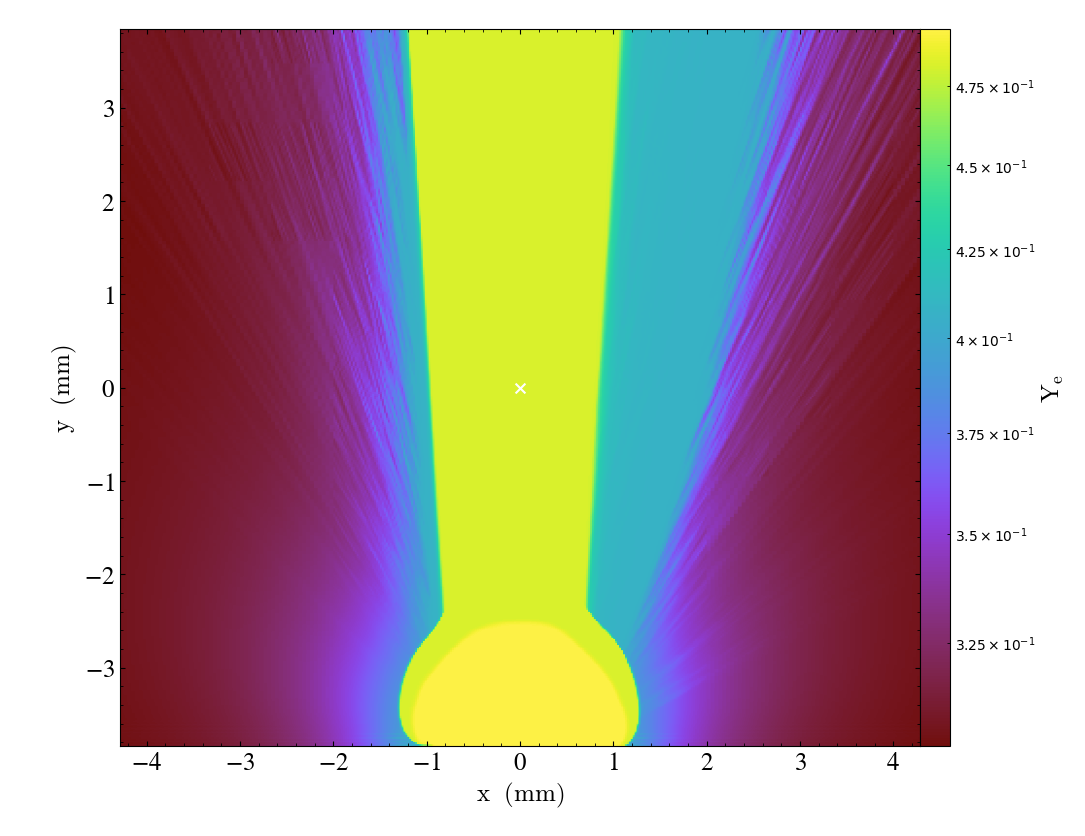

yt : [INFO     ] 2024-08-21 17:09:38,513 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:38,514 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:38,518 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 17:09:38,519 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 17:09:38,520 Making a fixed resolution buffer of (('flash', 'ye')) 800 by 800


ye at [0.   0.13 0.  ] code_length: [0.49372109] dimensionless



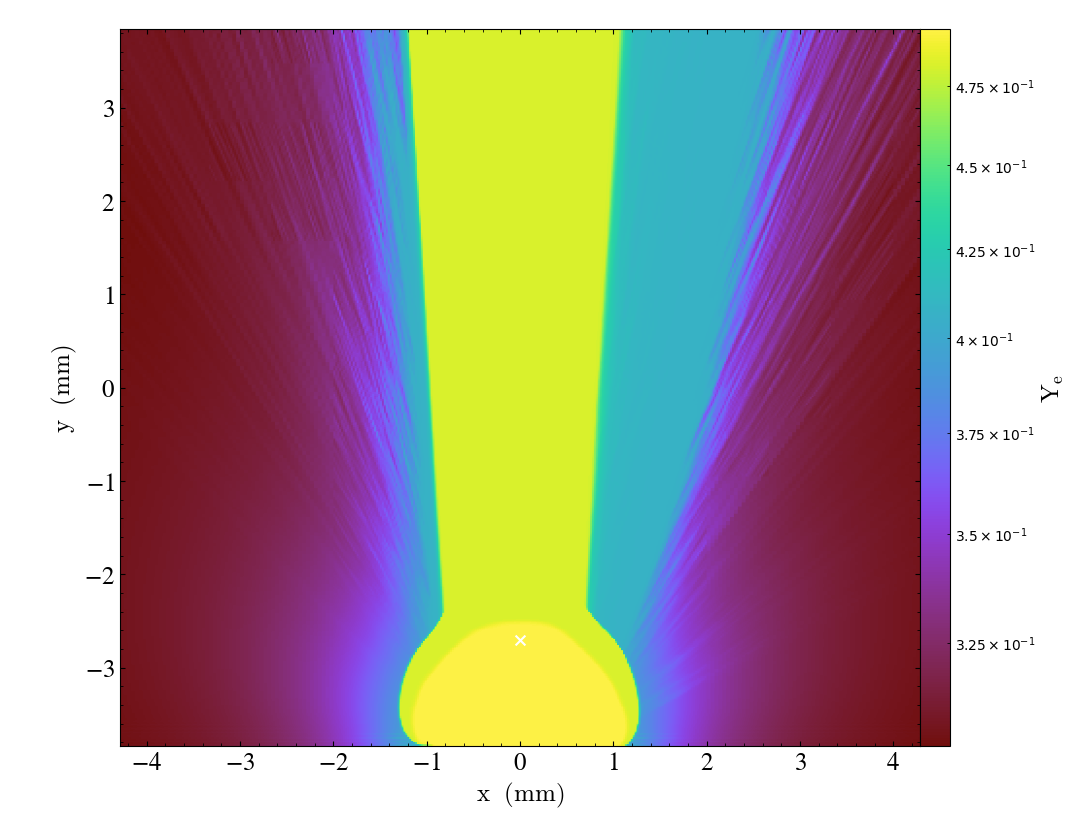

[8.86127003] dimensionless
[5.53557785e+17] code_mass/code_length**3


In [45]:
# background_pt = [-0.3, 0.12, 0.0]

ne_0 = pull_value_at_coord(background_pt,'ele_per_ion',ds)
ni_0 = pull_value_at_coord(background_pt,'idens',ds)

electron_per_baryon_channel = pull_value_at_coord(background_pt,'ye',ds)
electron_per_baryon_piston = pull_value_at_coord([0,0.13,0],'ye',ds)

print(ne_0/electron_per_baryon_channel - ne_0)
print(ni_0)

Get alfven speed from the value of background B field in simulation

### $v_a = \frac{B}{\sqrt{4 \pi \rho}}$

yt : [INFO     ] 2024-08-21 15:06:02,454 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:02,456 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:02,460 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:02,462 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:02,464 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800


magx at [0.  0.4 0. ] code_length: [110226.77212444] code_magnetic



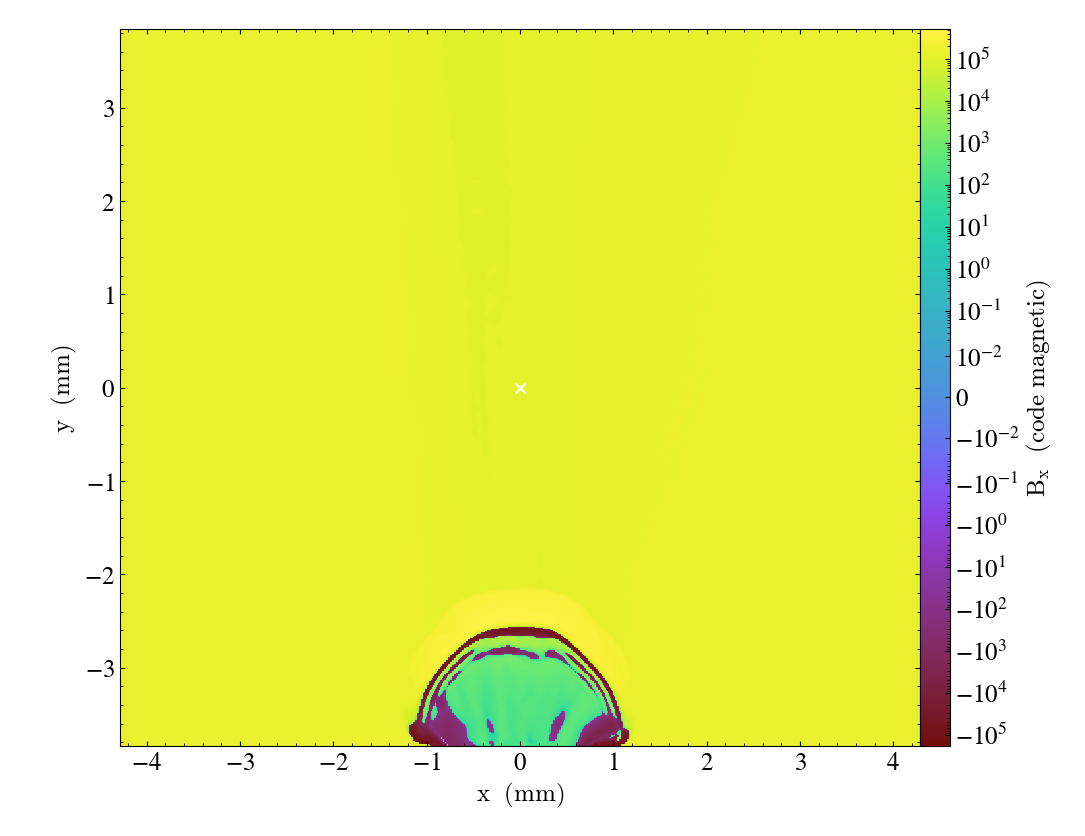

[6243815.75668848] code_length**(3/2)*code_magnetic/sqrt(code_mass)


In [8]:
Bx_0 = pull_value_at_coord(background_pt,'magx',ds)

v_alfven = Bx_0/np.sqrt(4*np.pi*rho_0)
print(v_alfven)

### Though it isn't visible in the above plot, there is actually a channel in the background magnetic field due to the incident laser

yt : [INFO     ] 2024-08-21 15:06:03,677 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:03,678 ylim = 0.062500 1.137500
yt : [INFO     ] 2024-08-21 15:06:03,682 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:03,683 ylim = 0.062500 1.137500
yt : [INFO     ] 2024-08-21 15:06:03,686 Making a fixed resolution buffer of (('flash', 'magx')) 800 by 800



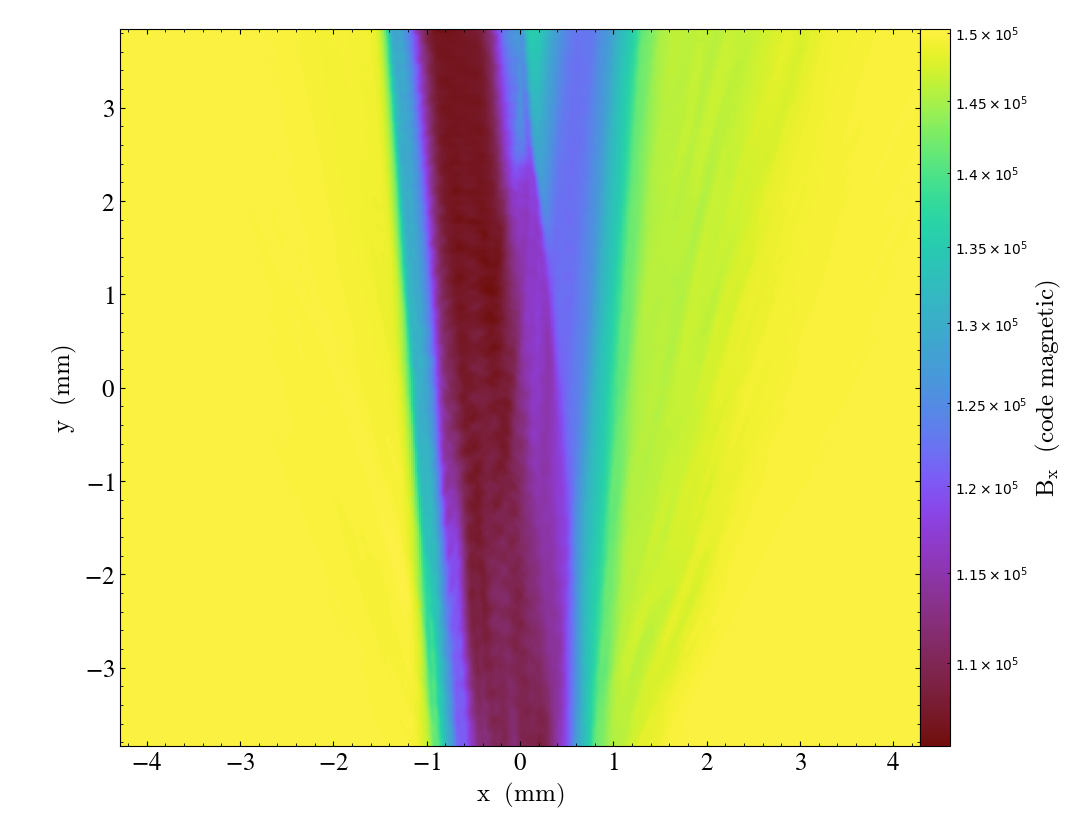

In [9]:
slc = yt.SlicePlot(ds, "z", "magx",center=[0,.6,0]).zoom(1.4)
slc.show()

Text(0, 0.5, 'Number Density [$cm^{-3}$]')

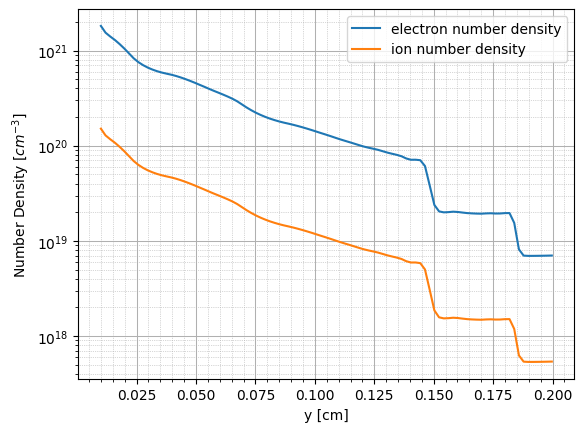

In [10]:
# Take a lineout of the number density to find where the target ends and where the piston begins
start_pt = (0.0,0.01,0.0)
end_pt = (0.0,0.2,0.0)
ray = ds.ray(start_pt, end_pt)

length_of_ray = np.sqrt((end_pt[0]-start_pt[0])**2 + (end_pt[1]-start_pt[1])**2 + (end_pt[2]-start_pt[2])**2)
dist_from_origin = np.sqrt(start_pt[0]**2 + start_pt[1]**2 + start_pt[2]**2)
ray_sort = np.argsort(ray["t"])
dist = np.array(ray[('t')]*length_of_ray+dist_from_origin)






y = np.array(ray[('flash','y')][ray_sort])
idens = np.array(ray[('flash','idens')][ray_sort])

edens = np.array(ray[('flash','edens')][ray_sort])
plt.semilogy(dist, edens, label='electron number density')
plt.semilogy(dist, idens, label='ion number density')
plt.legend()

from transform import pretty_plot
pretty_plot()


plt.xlabel('y [cm]')
plt.ylabel(r'Number Density [$cm^{-3}$]')
# based on this plot, it looks like the piston begins at y = 0.01

# print(edens[-200])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


mach number is between [3.69581088] sqrt(code_mass)/(code_length**(3/2)*code_magnetic) and [17.17601614] sqrt(code_mass)/(code_length**(3/2)*code_magnetic)


Text(0.5, 1.0, 'Velocity distribution of piston')

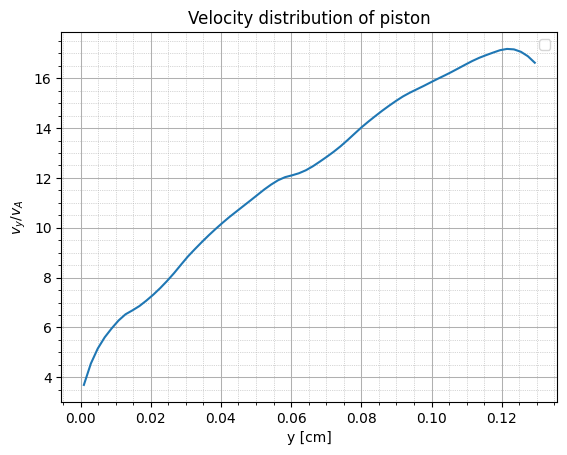

In [11]:
piston_ray = ds.ray((0, 0.01, 0), (0, .14, 0))
vely = np.array(piston_ray[('flash','vely')])
piston = np.array(piston_ray[('flash','y')])-0.01

plt.plot(piston, vely/v_alfven)
pretty_plot()
plt.legend()


mach_number_max = np.max(vely)/v_alfven
mach_number_min = np.min(vely)/v_alfven


print(f"mach number is between {mach_number_min} and {mach_number_max}")

plt.xlabel('y [cm]')
plt.ylabel(r'$v_y/v_A$')

plt.title('Velocity distribution of piston')
# plt.hlines(v_alfven, 0, 0.15, label='Alfven speed')

yt : [INFO     ] 2024-08-21 15:06:05,697 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:05,698 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:05,706 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:05,709 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:05,712 Making a fixed resolution buffer of (('flash', 'tion')) 800 by 800


tion at [0.  0.4 0. ] code_length: [1436956.15327951] code_temperature



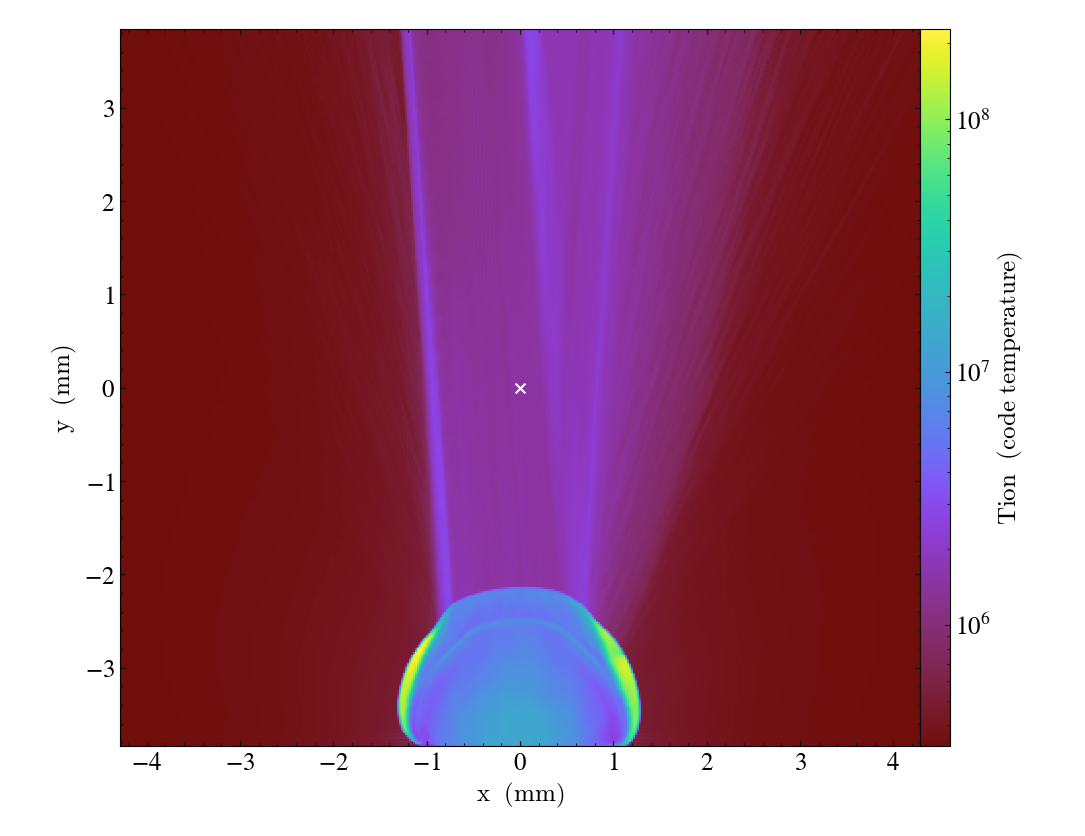

yt : [INFO     ] 2024-08-21 15:06:06,536 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:06,538 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:06,542 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:06,543 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:06,546 Making a fixed resolution buffer of (('flash', 'tele')) 800 by 800


tele at [0.  0.4 0. ] code_length: [12974580.64146048] code_temperature



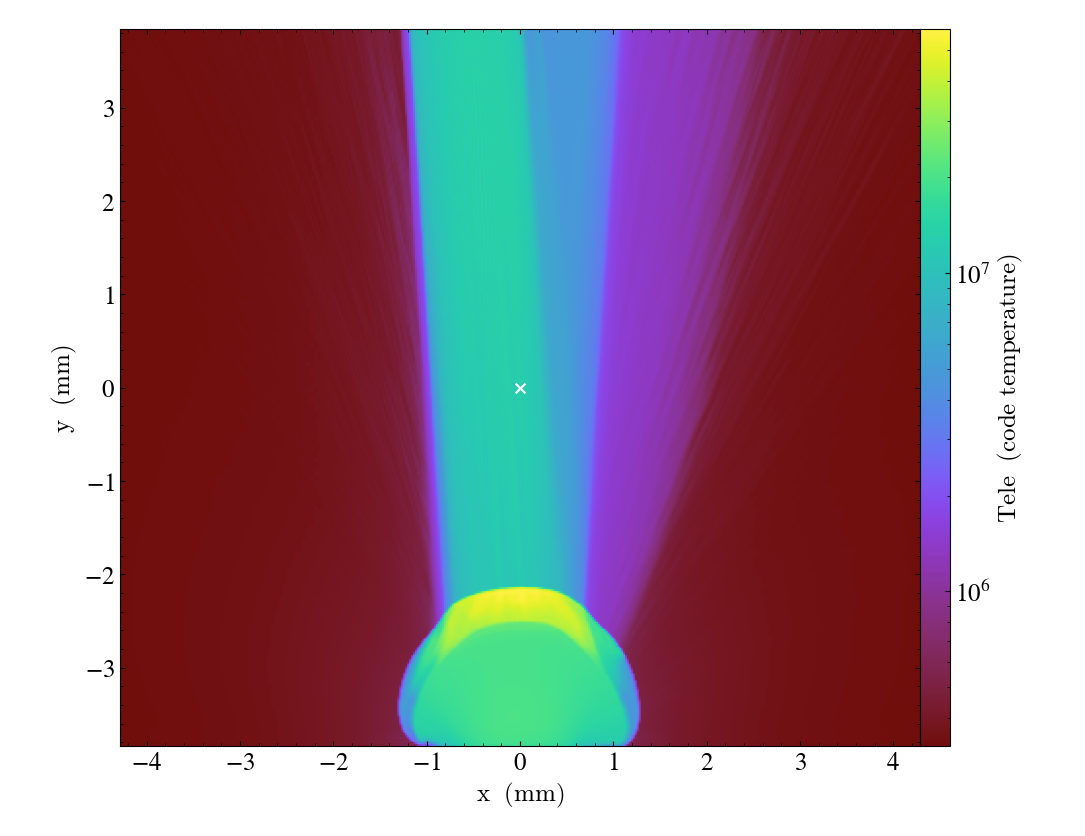

[-0.88924835] dimensionless


In [12]:
Ti_0 = pull_value_at_coord(background_pt,'tion',ds)

Te_0 = pull_value_at_coord(background_pt,'tele',ds)

print((Ti_0 - Te_0)/Te_0) # looks like the temperature difference is around 88%

## Now, start making (throwing) fits!

Some care needs to be taken with the fitting of the piston region and the compression after it. It looks like in the region around 750-900 [c/omega_pe], there is a compression of the background ions. Let's try to see if we can resolve this exactly

In [13]:
aluminum = pull_value_at_coord([0,0.20,0], "sumy",ds,plot = False)

magnesium = pull_value_at_coord([0,0.1,0], "sumy",ds, plot = False)

def make_magnesium_number_density(field, data):
    
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    mg_number_density = mg_percentage*data["flash","idens"]
    return mg_number_density

def make_aluminum_number_density(field, data):
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    al_number_density = (1-mg_percentage)*data["flash","idens"]
    return al_number_density


def make_magnesium_temp(field, data):
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    mg_temp = mg_percentage*data["flash","tion"]
    return mg_temp

def make_aluminum_temp(field, data):
    mg_percentage = (data["flash","sumy"]-aluminum)/(magnesium-aluminum)
    al_temp = (1-mg_percentage)*data["flash","tion"]
    return al_temp

ds.add_field(("flash", "mgdens"), function=make_magnesium_number_density, units="code_mass/code_length**3",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "aldens"), function=make_aluminum_number_density, units="code_mass/code_length**3",sampling_type="cell") # same here


ds.add_field(("flash", "mgtemp"), function=make_magnesium_temp, units="code_temperature",sampling_type="cell") # technically the units are wrong here, should be massless
ds.add_field(("flash", "altemp"), function=make_aluminum_temp, units="code_temperature",sampling_type="cell")

yt : [INFO     ] 2024-08-21 15:06:07,425 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:07,426 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:07,428 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:07,429 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:07,431 Making a fixed resolution buffer of (('flash', 'sumy')) 800 by 800
yt : [INFO     ] 2024-08-21 15:06:07,672 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:07,672 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:07,675 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:07,676 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:07,677 Making a fixed resolution buffer of (('flash', 'sumy')) 800 by 800


sumy at [0.  0.2 0. ] code_length: [0.03706449] dimensionless
sumy at [0.  0.1 0. ] code_length: [0.04114372] dimensionless


yt : [INFO     ] 2024-08-21 15:06:08,021 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:08,022 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:08,027 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:08,028 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:08,031 Making a fixed resolution buffer of (('flash', 'altemp')) 800 by 800


altemp at [0.   0.17 0.  ] code_length: [5771484.35154519] code_temperature



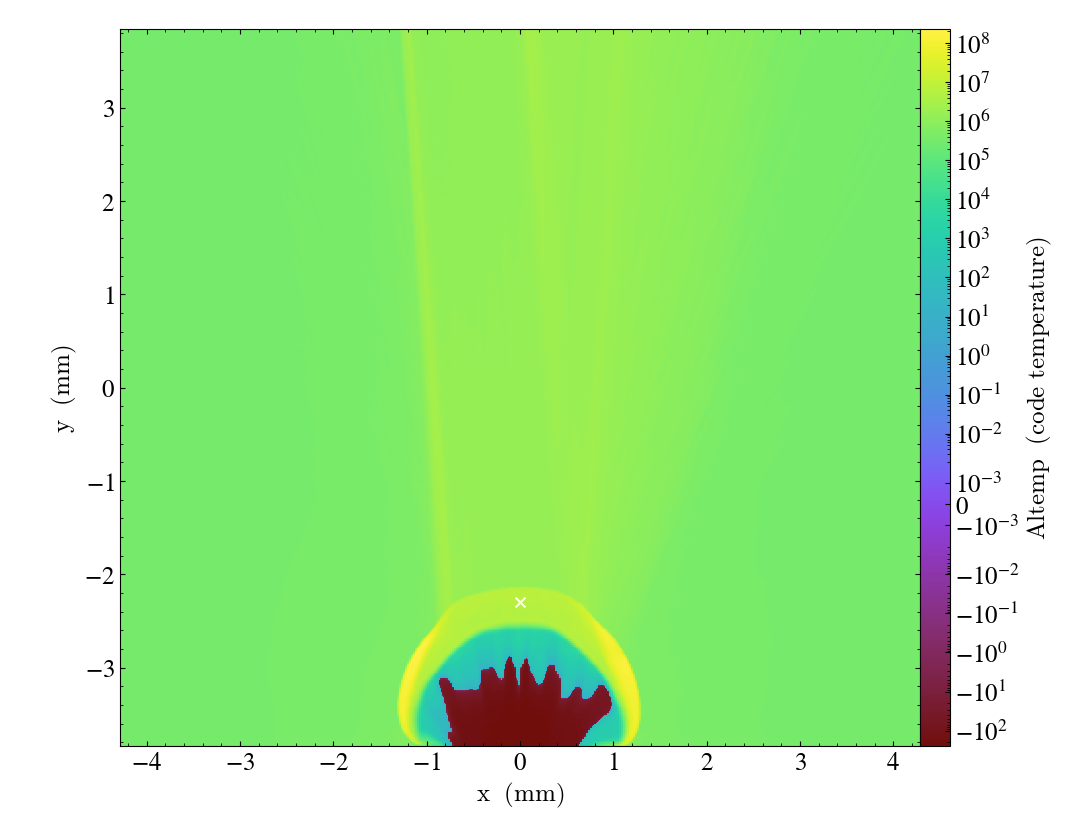

yt : [INFO     ] 2024-08-21 15:06:09,602 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:09,603 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:09,606 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:09,607 ylim = -0.137500 0.937500
yt : [INFO     ] 2024-08-21 15:06:09,609 Making a fixed resolution buffer of (('flash', 'mgtemp')) 800 by 800


mgtemp at [0.   0.17 0.  ] code_length: [7.08617039] code_temperature



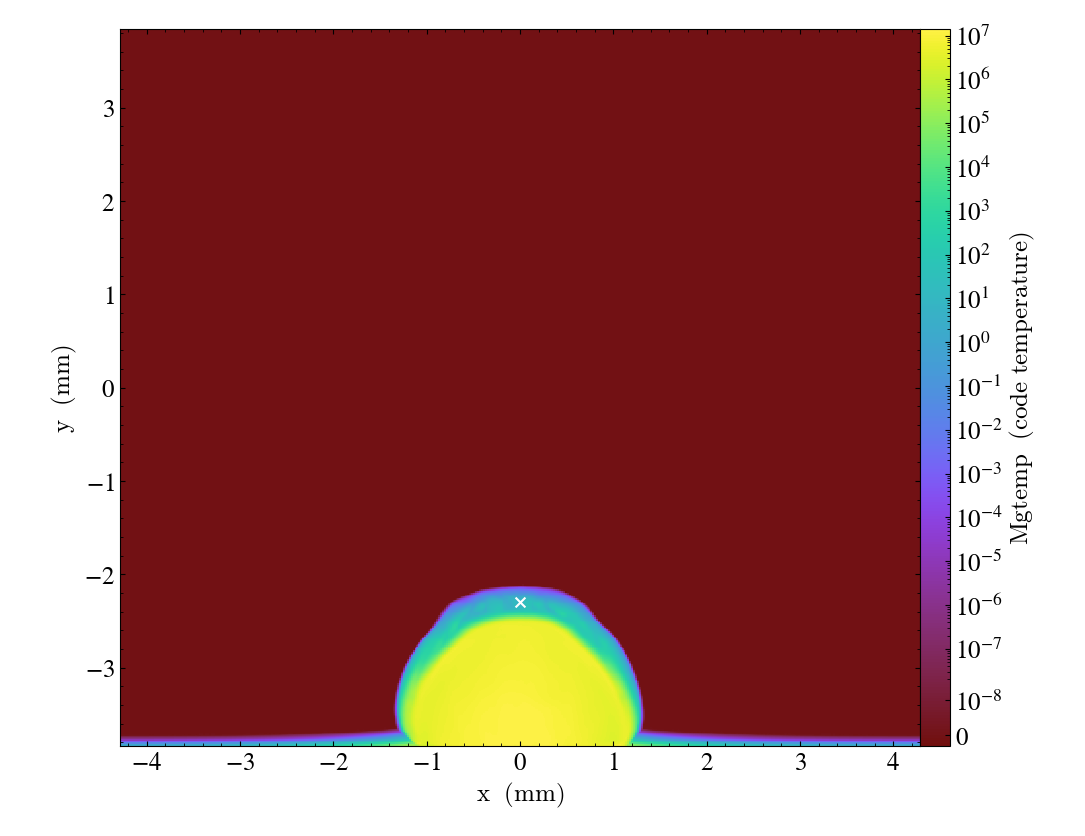

unyt_array([7.08617039], 'code_temperature')

In [14]:
pull_value_at_coord([0,.17,0],'altemp',ds)

pull_value_at_coord([0,.17,0],'mgtemp',ds)

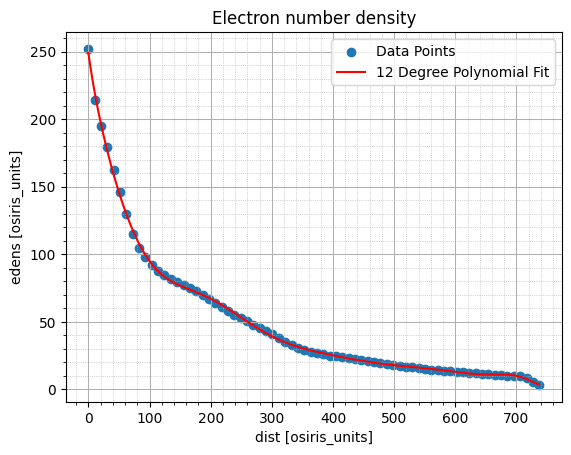

"if(x1 < 737.225996,  (6769186.770358)*((x1 - 0.0)/737.225996)^(12) + (-41971750.329278)*((x1 - 0.0)/737.225996)^(11) + (114099653.965361)*((x1 - 0.0)/737.225996)^(10) + (-178495881.635442)*((x1 - 0.0)/737.225996)^(9) + (177221940.014434)*((x1 - 0.0)/737.225996)^(8) + (-116097123.729442)*((x1 - 0.0)/737.225996)^(7) + (50522907.661904)*((x1 - 0.0)/737.225996)^(6) + (-14355212.131068)*((x1 - 0.0)/737.225996)^(5) + (2568735.269468)*((x1 - 0.0)/737.225996)^(4) + (-283625.077719)*((x1 - 0.0)/737.225996)^(3) + (23276.914664)*((x1 - 0.0)/737.225996)^(2) + (-2353.033727)*((x1 - 0.0)/737.225996)^(1) + (248.91508)*((x1 - 0.0)/737.225996)^(0), 0.0)",

----------Desmos formatting to check your work----------

(6769186.770358)*((x - 0.0)/737.225996)^12 + (-41971750.329278)*((x - 0.0)/737.225996)^11 + (114099653.965361)*((x - 0.0)/737.225996)^10 + (-178495881.635442)*((x - 0.0)/737.225996)^9 + (177221940.014434)*((x - 0.0)/737.225996)^8 + (-116097123.729442)*((x - 0.0)/737.225996)^7 + (50522907.6619

In [15]:
from fitting_functions import fit_to_region
pretty_plot()
plt.title('Electron number density')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.152,0.0],field='edens',degree=12,ds=ds, normalization=ne_0, osiris=osiris,precision=6,left_value=None, right_value=0.0)

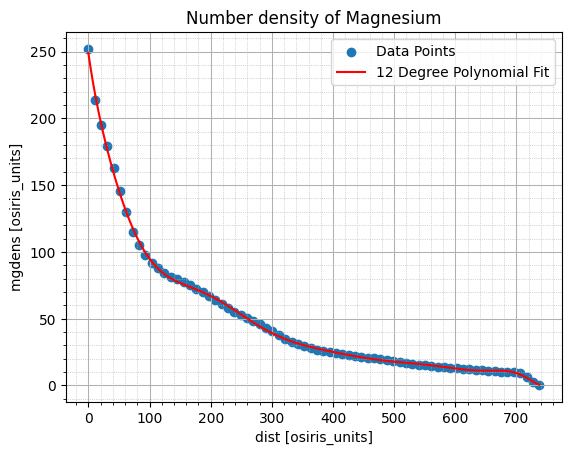

"if(x1 < 737.225996,  (7487918.972409)*((x1 - 0.0)/737.225996)^(12) + (-46133241.600891)*((x1 - 0.0)/737.225996)^(11) + (124625732.037395)*((x1 - 0.0)/737.225996)^(10) + (-193772101.23204)*((x1 - 0.0)/737.225996)^(9) + (191269318.287723)*((x1 - 0.0)/737.225996)^(8) + (-124626223.851062)*((x1 - 0.0)/737.225996)^(7) + (53978946.608980)*((x1 - 0.0)/737.225996)^(6) + (-15278511.522163)*((x1 - 0.0)/737.225996)^(5) + (2725625.599674)*((x1 - 0.0)/737.225996)^(4) + (-299451.943361)*((x1 - 0.0)/737.225996)^(3) + (24110.831142)*((x1 - 0.0)/737.225996)^(2) + (-2370.592522)*((x1 - 0.0)/737.225996)^(1) + (248.984330)*((x1 - 0.0)/737.225996)^(0), 0.0)",

----------Desmos formatting to check your work----------

(7487918.972409)*((x - 0.0)/737.225996)^12 + (-46133241.600891)*((x - 0.0)/737.225996)^11 + (124625732.037395)*((x - 0.0)/737.225996)^10 + (-193772101.23204)*((x - 0.0)/737.225996)^9 + (191269318.287723)*((x - 0.0)/737.225996)^8 + (-124626223.851062)*((x - 0.0)/737.225996)^7 + (53978946.60898

In [16]:
pretty_plot()
plt.title('Number density of Magnesium')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.152,0.0],field='mgdens',degree=12,ds=ds, normalization=ne_0/12, osiris=osiris,precision=6,left_value=None, right_value=0.0)

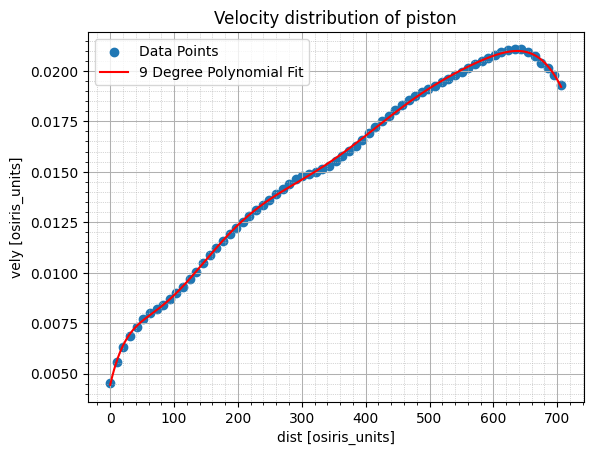

"(10.807269)*((x1 - 0.0)/706.069479)^(9) +(-55.658635)*((x1 - 0.0)/706.069479)^(8) +(120.243170)*((x1 - 0.0)/706.069479)^(7) +(-141.527931)*((x1 - 0.0)/706.069479)^(6) +(98.453921)*((x1 - 0.0)/706.069479)^(5) +(-41.015807)*((x1 - 0.0)/706.069479)^(4) +(9.890188)*((x1 - 0.0)/706.069479)^(3) +(-1.274996)*((x1 - 0.0)/706.069479)^(2) +(0.097579)*((x1 - 0.0)/706.069479)^(1) +(0.004446)*((x1 - 0.0)/706.069479)^(0)",

----------Desmos formatting to check your work----------

(10.807269)*((x - 0.0)/706.069479)^9 + (-55.658635)*((x - 0.0)/706.069479)^8 + (120.243170)*((x - 0.0)/706.069479)^7 + (-141.527931)*((x - 0.0)/706.069479)^6 + (98.453921)*((x - 0.0)/706.069479)^5 + (-41.015807)*((x - 0.0)/706.069479)^4 + (9.890188)*((x - 0.0)/706.069479)^3 + (-1.274996)*((x - 0.0)/706.069479)^2 + (0.097579)*((x - 0.0)/706.069479)^1 + (0.004446)*((x - 0.0)/706.069479)^0


In [17]:

pretty_plot()
plt.title('Velocity distribution of piston')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.145,0.0],field='vely',degree=9,ds=ds, normalization=v_alfven/ osiris['alfven_speed'], osiris=osiris,precision=6,left_value=None, right_value=None)

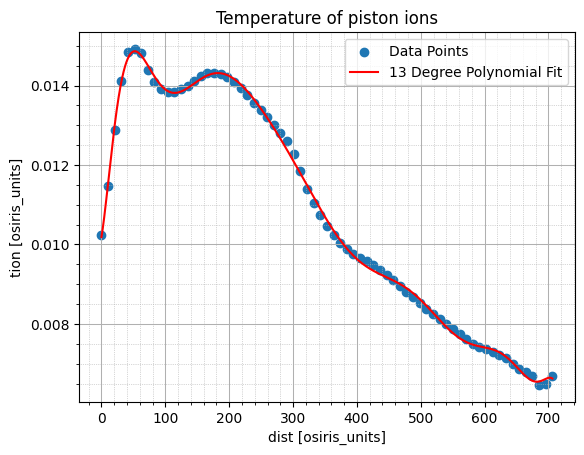

"(-4224.447033)*((x1 - 0.0)/706.069479)^(13) +(28186.188467)*((x1 - 0.0)/706.069479)^(12) +(-83484.200884)*((x1 - 0.0)/706.069479)^(11) +(144638.626567)*((x1 - 0.0)/706.069479)^(10) +(-162561.107529)*((x1 - 0.0)/706.069479)^(9) +(124192.704088)*((x1 - 0.0)/706.069479)^(8) +(-65653.499902)*((x1 - 0.0)/706.069479)^(7) +(23941.788976)*((x1 - 0.0)/706.069479)^(6) +(-5874.806875)*((x1 - 0.0)/706.069479)^(5) +(916.129992)*((x1 - 0.0)/706.069479)^(4) +(-80.072220)*((x1 - 0.0)/706.069479)^(3) +(2.624100)*((x1 - 0.0)/706.069479)^(2) +(0.068692)*((x1 - 0.0)/706.069479)^(1) +(0.010186)*((x1 - 0.0)/706.069479)^(0)",

----------Desmos formatting to check your work----------

(-4224.447033)*((x - 0.0)/706.069479)^13 + (28186.188467)*((x - 0.0)/706.069479)^12 + (-83484.200884)*((x - 0.0)/706.069479)^11 + (144638.626567)*((x - 0.0)/706.069479)^10 + (-162561.107529)*((x - 0.0)/706.069479)^9 + (124192.704088)*((x - 0.0)/706.069479)^8 + (-65653.499902)*((x - 0.0)/706.069479)^7 + (23941.788976)*((x - 0.0)

In [18]:
pretty_plot()
plt.title('Temperature of piston ions')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.145,0.0],field='tion',degree=13,ds=ds, normalization=Ti_0.value/osiris['Tpiston'], osiris=osiris,precision=6,left_value=None, right_value=None)

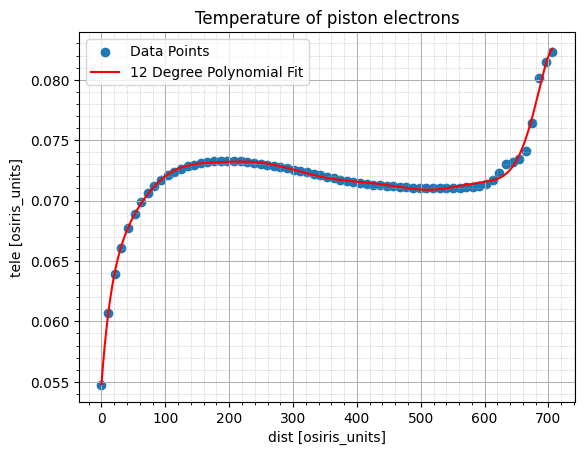

"(-2002.296822)*((x1 - 0.0)/706.069479)^(12) +(11911.241309)*((x1 - 0.0)/706.069479)^(11) +(-31149.416230)*((x1 - 0.0)/706.069479)^(10) +(47112.151912)*((x1 - 0.0)/706.069479)^(9) +(-45621.938882)*((x1 - 0.0)/706.069479)^(8) +(29588.544452)*((x1 - 0.0)/706.069479)^(7) +(-13071.677837)*((x1 - 0.0)/706.069479)^(6) +(3928.925134)*((x1 - 0.0)/706.069479)^(5) +(-791.458151)*((x1 - 0.0)/706.069479)^(4) +(104.304647)*((x1 - 0.0)/706.069479)^(3) +(-8.854014)*((x1 - 0.0)/706.069479)^(2) +(0.502252)*((x1 - 0.0)/706.069479)^(1) +(0.054791)*((x1 - 0.0)/706.069479)^(0)",

----------Desmos formatting to check your work----------

(-2002.296822)*((x - 0.0)/706.069479)^12 + (11911.241309)*((x - 0.0)/706.069479)^11 + (-31149.416230)*((x - 0.0)/706.069479)^10 + (47112.151912)*((x - 0.0)/706.069479)^9 + (-45621.938882)*((x - 0.0)/706.069479)^8 + (29588.544452)*((x - 0.0)/706.069479)^7 + (-13071.677837)*((x - 0.0)/706.069479)^6 + (3928.925134)*((x - 0.0)/706.069479)^5 + (-791.458151)*((x - 0.0)/706.069479

In [19]:
pretty_plot()
plt.title('Temperature of piston electrons')
fit_to_region(start_pt=[0.0,0.01,0.0],end_pt=[0.0,0.145,0.0],field='tele',degree=12,ds=ds, normalization=Te_0.value/osiris['Te'], osiris=osiris,precision=6,left_value=None, right_value=None)

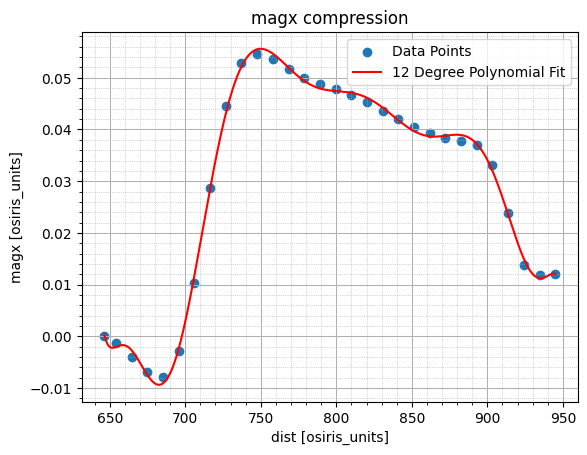

"if(x1 < 646.432523, 0, if(x1 < 944.936112,  (3529.714887)*((x1 - 646.432523)/298.503588)^(12) + (-26785.969127)*((x1 - 646.432523)/298.503588)^(11) + (86781.804418)*((x1 - 646.432523)/298.503588)^(10) + (-158521.37377)*((x1 - 646.432523)/298.503588)^(9) + (180749.225765)*((x1 - 646.432523)/298.503588)^(8) + (-134021.489965)*((x1 - 646.432523)/298.503588)^(7) + (65059.204101)*((x1 - 646.432523)/298.503588)^(6) + (-20223.400077)*((x1 - 646.432523)/298.503588)^(5) + (3802.742049)*((x1 - 646.432523)/298.503588)^(4) + (-388.670963)*((x1 - 646.432523)/298.503588)^(3) + (18.594250)*((x1 - 646.432523)/298.503588)^(2) + (-0.369772)*((x1 - 646.432523)/298.503588)^(1) + (0.000316)*((x1 - 646.432523)/298.503588)^(0), 0.012))",

----------Desmos formatting to check your work----------

(3529.714887)*((x - 646.432523)/298.503588)^12 + (-26785.969127)*((x - 646.432523)/298.503588)^11 + (86781.804418)*((x - 646.432523)/298.503588)^10 + (-158521.37377)*((x - 646.432523)/298.503588)^9 + (180749.225765)

In [20]:
pretty_plot()
plt.title('magx compression')
fit_to_region(start_pt=[0.0,0.133,0.0],end_pt=[0.0,0.19,0.0],field='magx',degree=12,ds=ds, normalization=Bx_0.value/ osiris['B'], osiris=osiris,precision=6,left_value=0, right_value=osiris['B'])

In [21]:
def make_Ex(field, data):
    Ex = data['flash','velz']*data["flash","magy"]-data["flash","vely"]*data["flash","magz"]
    return Ex

def make_Ey(field, data):
    Ey = data['flash','velx']*data["flash","magz"]-data["flash","velz"]*data["flash","magx"]
    return Ey

def make_Ez(field, data):
    Ez = data['flash','vely']*data["flash","magx"]-data["flash","velx"]*data["flash","magy"]
    return Ez

ds.add_field(("flash", "Ex"), function=make_Ex, units="code_magnetic*code_length/code_time",sampling_type="cell") #technically the units are wrong here
ds.add_field(("flash", "Ey"), function=make_Ey, units="code_magnetic*code_length/code_time",sampling_type="cell")
ds.add_field(("flash", "Ez"), function=make_Ez, units="code_magnetic*code_length/code_time",sampling_type="cell")

yt : [INFO     ] 2024-08-21 15:06:13,372 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:13,373 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-21 15:06:13,377 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-08-21 15:06:13,379 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-08-21 15:06:13,381 Making a fixed resolution buffer of (('flash', 'Ez')) 800 by 800



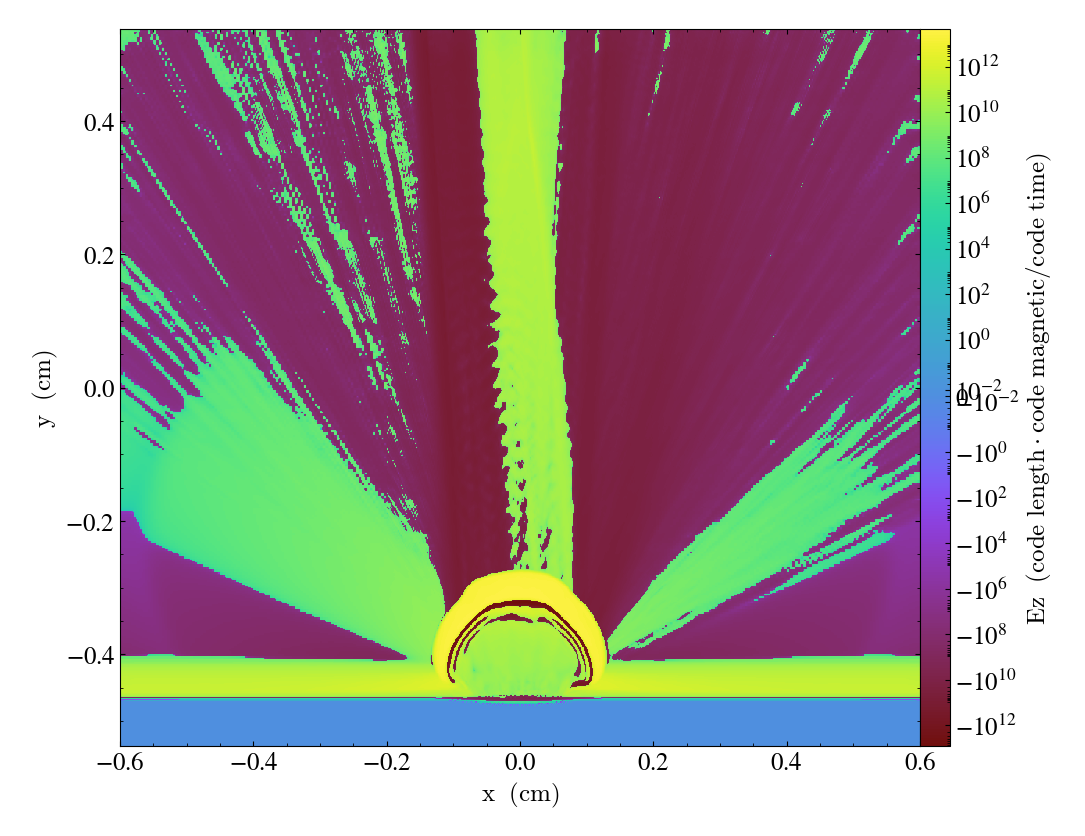

In [22]:
yt.SlicePlot(ds, 'z', ('flash', 'Ez')).show()


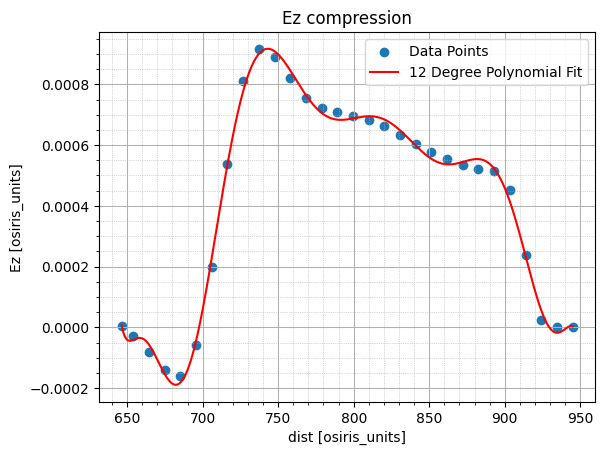

"if(x1 < 646.432523, 0, if(x1 < 944.936112,  (84.516845)*((x1 - 646.432523)/298.503588)^(12) + (-628.629510)*((x1 - 646.432523)/298.503588)^(11) + (2002.791657)*((x1 - 646.432523)/298.503588)^(10) + (-3603.519246)*((x1 - 646.432523)/298.503588)^(9) + (4049.286421)*((x1 - 646.432523)/298.503588)^(8) + (-2958.110245)*((x1 - 646.432523)/298.503588)^(7) + (1413.481378)*((x1 - 646.432523)/298.503588)^(6) + (-431.937437)*((x1 - 646.432523)/298.503588)^(5) + (79.759029)*((x1 - 646.432523)/298.503588)^(4) + (-8.008078)*((x1 - 646.432523)/298.503588)^(3) + (0.376584)*((x1 - 646.432523)/298.503588)^(2) + (-0.007402)*((x1 - 646.432523)/298.503588)^(1) + (0.000006)*((x1 - 646.432523)/298.503588)^(0), 0.0))",

----------Desmos formatting to check your work----------

(84.516845)*((x - 646.432523)/298.503588)^12 + (-628.629510)*((x - 646.432523)/298.503588)^11 + (2002.791657)*((x - 646.432523)/298.503588)^10 + (-3603.519246)*((x - 646.432523)/298.503588)^9 + (4049.286421)*((x - 646.432523)/298.50358

In [23]:
pretty_plot()
plt.title('Ez compression')
fit_to_region(start_pt=[0.0,0.133,0.0],end_pt=[0.0,0.19,0.0],field='Ez',degree=12,ds=ds, normalization=Bx_0.value/ osiris['B']*v_alfven/osiris['alfven_speed'], osiris=osiris,precision=6,left_value=0, right_value=0.0)

Get the density compression of the aluminum plasma

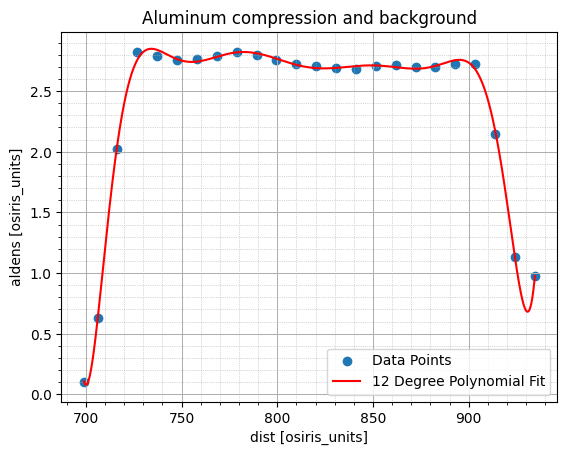

"if(x1 < 698.988, 0.0, if(x1 < 934.5506,  (153756.6928)*((x1 - 698.988)/235.5626)^(12) + (-940360.0352)*((x1 - 698.988)/235.5626)^(11) + (2599955.0582)*((x1 - 698.988)/235.5626)^(10) + (-4285529.6428)*((x1 - 698.988)/235.5626)^(9) + (4661673.4889)*((x1 - 698.988)/235.5626)^(8) + (-3489458.7109)*((x1 - 698.988)/235.5626)^(7) + (1815320.9510)*((x1 - 698.988)/235.5626)^(6) + (-647104.6089)*((x1 - 698.988)/235.5626)^(5) + (151794.3295)*((x1 - 698.988)/235.5626)^(4) + (-21539.3082)*((x1 - 698.988)/235.5626)^(3) + (1505.3188)*((x1 - 698.988)/235.5626)^(2) + (-12.6658)*((x1 - 698.988)/235.5626)^(1) + (0.1078)*((x1 - 698.988)/235.5626)^(0), 1.0))",

----------Desmos formatting to check your work----------

(153756.6928)*((x - 698.988)/235.5626)^12 + (-940360.0352)*((x - 698.988)/235.5626)^11 + (2599955.0582)*((x - 698.988)/235.5626)^10 + (-4285529.6428)*((x - 698.988)/235.5626)^9 + (4661673.4889)*((x - 698.988)/235.5626)^8 + (-3489458.7109)*((x - 698.988)/235.5626)^7 + (1815320.9510)*((x - 698

In [41]:
pretty_plot()
plt.title('Aluminum compression and background')
fit_to_region(start_pt=[0.0,0.143,0.0],end_pt=[0.0,0.188,0.0],field='aldens',degree=12,ds=ds, normalization=ne_0/13, osiris=osiris,precision=4,left_value=0.0, right_value=1.0)

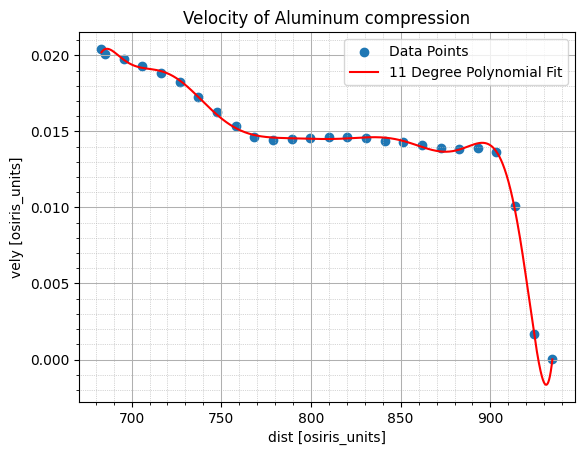

"if(x1 < 683.221366, 0.02, if(x1 < 934.550606,  (867.681766)*((x1 - 683.221366)/251.32924)^(11) + (-4520.608618)*((x1 - 683.221366)/251.32924)^(10) + (10179.697114)*((x1 - 683.221366)/251.32924)^(9) + (-12975.478631)*((x1 - 683.221366)/251.32924)^(8) + (10290.935821)*((x1 - 683.221366)/251.32924)^(7) + (-5251.591462)*((x1 - 683.221366)/251.32924)^(6) + (1720.142333)*((x1 - 683.221366)/251.32924)^(5) + (-349.229600)*((x1 - 683.221366)/251.32924)^(4) + (40.79451)*((x1 - 683.221366)/251.32924)^(3) + (-2.406016)*((x1 - 683.221366)/251.32924)^(2) + (0.04259)*((x1 - 683.221366)/251.32924)^(1) + (0.020203)*((x1 - 683.221366)/251.32924)^(0), 0.0))",

----------Desmos formatting to check your work----------

(867.681766)*((x - 683.221366)/251.32924)^11 + (-4520.608618)*((x - 683.221366)/251.32924)^10 + (10179.697114)*((x - 683.221366)/251.32924)^9 + (-12975.478631)*((x - 683.221366)/251.32924)^8 + (10290.935821)*((x - 683.221366)/251.32924)^7 + (-5251.591462)*((x - 683.221366)/251.32924)^6 + (1

In [25]:
pretty_plot()
plt.title('Velocity of Aluminum compression')
fit_to_region(start_pt=[0.0,0.14,0.0],end_pt=[0.0,0.188,0.0],field='vely',degree=11,ds=ds, normalization=v_alfven/osiris['alfven_speed'], osiris=osiris,precision=6,left_value=0.02, right_value=0.0)

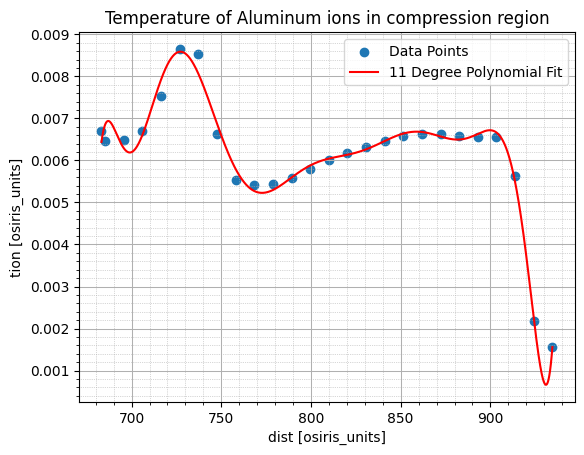

"if(x1 < 934.550606,  (924.28228)*((x1 - 683.221366)/251.32924)^(11) + (-5080.959095)*((x1 - 683.221366)/251.32924)^(10) + (12108.706230)*((x1 - 683.221366)/251.32924)^(9) + (-16375.86965)*((x1 - 683.221366)/251.32924)^(8) + (13805.38767)*((x1 - 683.221366)/251.32924)^(7) + (-7493.975845)*((x1 - 683.221366)/251.32924)^(6) + (2607.83234)*((x1 - 683.221366)/251.32924)^(5) + (-559.308801)*((x1 - 683.221366)/251.32924)^(4) + (67.721410)*((x1 - 683.221366)/251.32924)^(3) + (-3.89974)*((x1 - 683.221366)/251.32924)^(2) + (0.078320)*((x1 - 683.221366)/251.32924)^(1) + (0.006439)*((x1 - 683.221366)/251.32924)^(0), 0.0016)",

----------Desmos formatting to check your work----------

(924.28228)*((x - 683.221366)/251.32924)^11 + (-5080.959095)*((x - 683.221366)/251.32924)^10 + (12108.706230)*((x - 683.221366)/251.32924)^9 + (-16375.86965)*((x - 683.221366)/251.32924)^8 + (13805.38767)*((x - 683.221366)/251.32924)^7 + (-7493.975845)*((x - 683.221366)/251.32924)^6 + (2607.83234)*((x - 683.221366)/2

In [26]:
pretty_plot()
plt.title('Temperature of Aluminum ions in compression region')
fit_to_region(start_pt=[0.0,0.14,0.0],end_pt=[0.0,0.188,0.0],field='tion', degree=11,ds=ds, normalization= Ti_0/osiris['Tpiston'], osiris=osiris, precision=6,left_value=None, right_value=round(osiris['Tpiston'],4))

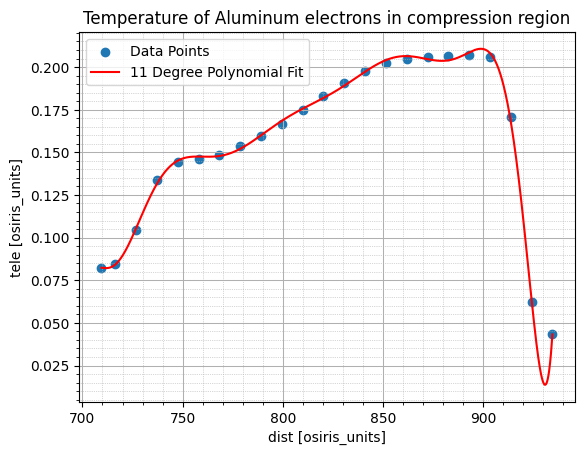

"if(x1 < 934.55060604,  (10384.9844337)*((x1 - 709.49911105)/225.05149499)^(11) + (-53000.8821021)*((x1 - 709.49911105)/225.05149499)^(10) + (116181.517507)*((x1 - 709.49911105)/225.05149499)^(9) + (-142880.13694829)*((x1 - 709.49911105)/225.05149499)^(8) + (107899.31593896)*((x1 - 709.49911105)/225.05149499)^(7) + (-51341.37226508)*((x1 - 709.49911105)/225.05149499)^(6) + (15105.80210014)*((x1 - 709.49911105)/225.05149499)^(5) + (-2543.73135108)*((x1 - 709.49911105)/225.05149499)^(4) + (195.51264147)*((x1 - 709.49911105)/225.05149499)^(3) + (-1.01957422)*((x1 - 709.49911105)/225.05149499)^(2) + (-0.02948288)*((x1 - 709.49911105)/225.05149499)^(1) + (0.08233878)*((x1 - 709.49911105)/225.05149499)^(0), 0.0468)",

----------Desmos formatting to check your work----------

(10384.9844337)*((x - 709.49911105)/225.05149499)^11 + (-53000.8821021)*((x - 709.49911105)/225.05149499)^10 + (116181.517507)*((x - 709.49911105)/225.05149499)^9 + (-142880.13694829)*((x - 709.49911105)/225.05149499)^8 

In [36]:
pretty_plot()
plt.title('Temperature of Aluminum electrons in compression region')
fit_to_region(start_pt=[0.0,0.145,0.0],end_pt=[0.0,0.189,0.0],field='tele', degree=11,ds=ds, normalization= Te_0.value/osiris['Te'], osiris=osiris, precision=8,left_value=None, right_value=round(osiris['Te'],4))